## Overfitting
### Explore bias-variance tradeoff visually
### See what overfitting looks like

In [1]:
from ml_helper import helper
import numpy as np
import numpy.random as npr
import numpy.linalg as nlg
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from warnings import filterwarnings
filterwarnings('ignore', message='.*')

In [2]:
%%capture
def generate_fit(n_data, degree):
    
    lbd = 0.00
    LB = 1
    UB = 4
    
    if degree >= n_data:
        print("Reducing degree to equal one less than the number of points!")
        degree = n_data - 1
    
    
    YNOISE = 0.3
    XNOISE = 0.0
    
    NVAL = 50
    
    def func(x):
        return np.log(x) + 0.5 * np.sin(3 * x) + x * 0.5
    
    def x_to_X(x):
        out = np.zeros((len(x), degree + 1))
        for i in range(degree + 1):
            out[:, i] = x ** i
        return out
    
    npr.seed(13371387)
    
    x_raw = np.linspace(LB, UB, num=NVAL) + npr.normal(scale=XNOISE, size=NVAL)
    y_raw = func(x_raw) + npr.normal(scale=YNOISE, size=NVAL)
    
    ixes = npr.permutation(NVAL)
    
    x = x_raw[ixes[:n_data]]
    y = y_raw[ixes[:n_data]]
    
    xv = np.linspace(LB, UB, num=NVAL) + npr.normal(scale=XNOISE, size=NVAL)
    yv = func(xv) + npr.normal(scale=YNOISE, size=NVAL)
    
    X = x_to_X(x)
    
    coef = nlg.inv(X.T @ X + lbd * n_data * np.eye(degree + 1)) @ X.T @ y
    
    x_fit = np.linspace(np.min(xv), np.max(xv), num=NVAL)
    X_fit = x_to_X(x_fit)
    y_fit = X_fit @ coef
    
    plt.cla()
    
    # training plot
    plt.subplot(1, 2, 1)
    plt.plot(x_fit, y_fit)
    plt.scatter(x, y)
    plt.ylim((0, 4))
    
    ytfit = X @ coef
    loss = np.mean((y - ytfit)**2)
    st2 = np.sum((y - np.mean(y))**2)
    rt2 = np.sum((y - ytfit)**2)
    plt.title(f"Train set: $R^2$ {1- rt2/st2:0.2f}")
    
    # validation plot
    plt.subplot(1, 2, 2)
    plt.plot(x_fit, y_fit)
    plt.scatter(xv, yv)
    plt.ylim((0, 4))

    Xv = x_to_X(xv)
    yvfit = Xv @ coef
    loss = np.mean((yv - yvfit)**2)
    sv2 = np.sum((yv - np.mean(yv))**2)
    rv2 = np.sum((yv - yvfit)**2)
    plt.title(f"Test set: $R^2$ {1 - rv2/sv2:0.2f}") 
    
    # epilogue
    plt.gcf().set_size_inches((14, 6))
    plt.show()
    
    return (1 - rt2/st2, 1 - rv2/sv2)

In [3]:
interact(generate_fit,
         n_data=widgets.IntSlider(min=2,max=30,step=1,value=10),
         degree=widgets.IntSlider(min=1,max=5,step=1,value=3));

interactive(children=(IntSlider(value=10, description='n_data', max=30, min=2), IntSlider(value=3, description…

## The Bias-Variance tradeoff
Our observations in the "Decision Surfaces" notebook and the above demo bring us to a very important concept:
the **bias-variance tradeoff**.

Because our input data is imperfect, our modell will err, and there are two fundamental types of error we play off against each other. The first is **bias**, or the inability of our model to capture the true shape of our data. The second is **variance**, or the error from the noise in our model parameters we get as a result of noise in our input data.

Generally, there is a sweet spot where our model is complex enough to model our input, but not so complex that it has enough parameters to "chase noise" and **fail to generalize**. We will illustrate this below:

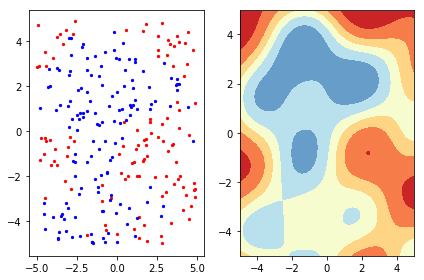

In [4]:
# First, let's generate some nice planar data and split it into training and validation sets

def get_and_plot_data(seed=9999):
    npr.seed(9999)
    X, y, true_model = helper.gen_planar_samples()
       
    f = plt.figure()
    helper.plot_red_blue(X, y, ax=plt.subplot(1, 2, 1))
    helper.plot_decision_surface(true_model, ax=plt.subplot(1, 2, 2))
    
    return X, y

# We use a validation set to model data we have not seen before and want to learn
from sklearn.model_selection import train_test_split
X_tr, X_v, y_tr, y_v = train_test_split(*get_and_plot_data())

The bias-variance effect is canonically illustrated with a training curve, showing both the training and validation loss as a function of model complexity. While the training loss goes down monotonically in all but pathological cases, the validation loss ticks up when the model becomes too complex for the amount of data.

In [5]:
# Knn is a good classifier to illustrate this effect
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.neural_network import MLPClassifier as MLP

**Exercise**: what is "model complexity" for the KNN classifier?

In [7]:
def plot_training_curves(model='svc'):
    scores_tr = []
    scores_v = []
    
    model = model.lower()
    
    if model == 'svc':
        complexityspace = np.logspace(-4, 2, num=25)
    elif model == 'knn':
        complexityspace = range(101, 0, -4)
    elif model == 'tree':
        complexityspace = range(1, 26, 1)
    elif model == 'mlp':
        complexityspace = range(1, 10, 1)
    else:
        raise ValueError('Unknown model!')

    # average over a number of randomizations to get smoother curves
    for smoothing_iteration in range(5):
        
        scores_tr.append([])
        scores_v.append([])
        
        X_tr, X_v, y_tr, y_v = train_test_split(*helper.gen_planar_samples(seed=smoothing_iteration*999)[:2])
        
        for parameter in complexityspace:
            
            if model == 'svc':
                m = SVC(kernel='rbf', gamma=parameter)
            elif model == 'knn':
                m = KNN(n_neighbors=parameter)
            elif model == 'tree':
                m = DTC(max_depth=parameter)
            elif model == 'mlp':
                m = MLP(hidden_layer_sizes=(20 * (1 + parameter // 3),) * (1 + parameter // 2))
            
            m.fit(X_tr, y_tr)
            
            scores_tr[-1].append(m.score(X_tr, y_tr))
            scores_v[-1].append(m.score(X_v, y_v))
    
    # smooth over iterations
    scores_tr = np.mean(scores_tr, axis=0)
    scores_v = np.mean(scores_v, axis=0)
    
    # plot against "abstract complexity", abstract away actual parameter values
    plt.plot(scores_tr, label='Training scores')
    plt.plot(scores_v, label='Validation scores')
    plt.xlabel('Complexity')
    plt.ylabel('Score')
    plt.legend()
    plt.ylim((0.5, 1))
    plt.gcf().set_size_inches(14, 8)
    plt.show()
    
interact(plot_training_curves,
         model=widgets.RadioButtons(options=['svc', 'knn', 'tree', 'mlp'])
        );

interactive(children=(RadioButtons(description='model', options=('svc', 'knn', 'tree', 'mlp'), value='svc'), O…